In [2]:
import os
import random
import glob
import cv2
import platform
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import albumentations as A
import matplotlib.pyplot as plt
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from torch.optim.lr_scheduler import CosineAnnealingLR
from tqdm.auto import tqdm
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')




/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.5' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
2025-04-26 21:41:59.585096: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745703719.772416      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745703719.827142      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Анализ данных

In [3]:
def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

seed_everything()

device = torch.device(
    "mps" if (torch.backends.mps.is_available() and platform.machine()=="arm64")
    else ("cuda" if torch.cuda.is_available() else "cpu")
)

num_workers = 0

use_amp = (device.type == "cuda")

writer = SummaryWriter("runs/eff_b0_mps")

train_root = '/train'
test_root  = '/test'

classes=sorted(os.listdir(train_root)); class2idx={c:i for i,c in enumerate(classes)}

paths, labels = [], []
for c in classes:
    for p in glob.glob(os.path.join(train_root, c, '*')):
        paths.append(p)
        labels.append(class2idx[c])

df = pd.DataFrame({'path': paths, 'label': labels})

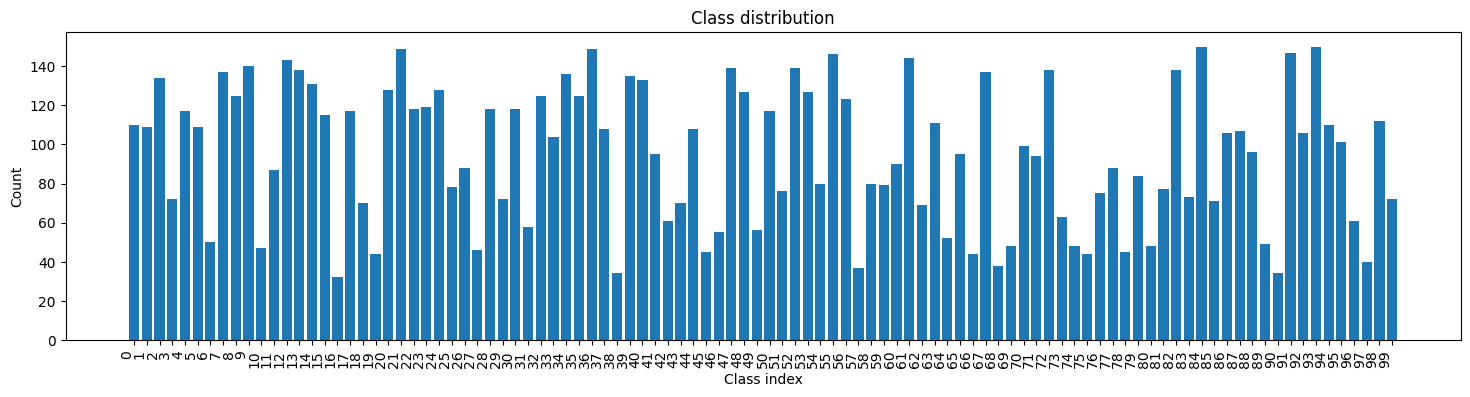

Количество классов: 100
Количество обучающих изображений: 9510
Минимум/максимум изображений в классах: 32 / 150


In [21]:
# баланс классов
class_counts = df['label'].value_counts().sort_index()
plt.figure(figsize=(18,4))
plt.bar(range(len(class_counts)), class_counts.values, tick_label=class_counts.index,)
plt.title("Class distribution")
plt.xlabel("Class index")
plt.ylabel("Count")
plt.xticks(rotation=90, ha='right')
plt.show()

print("Количество классов:", len(classes))
print("Количество обучающих изображений:", len(df))
print("Минимум/максимум изображений в классах:", class_counts.min(), "/", class_counts.max())

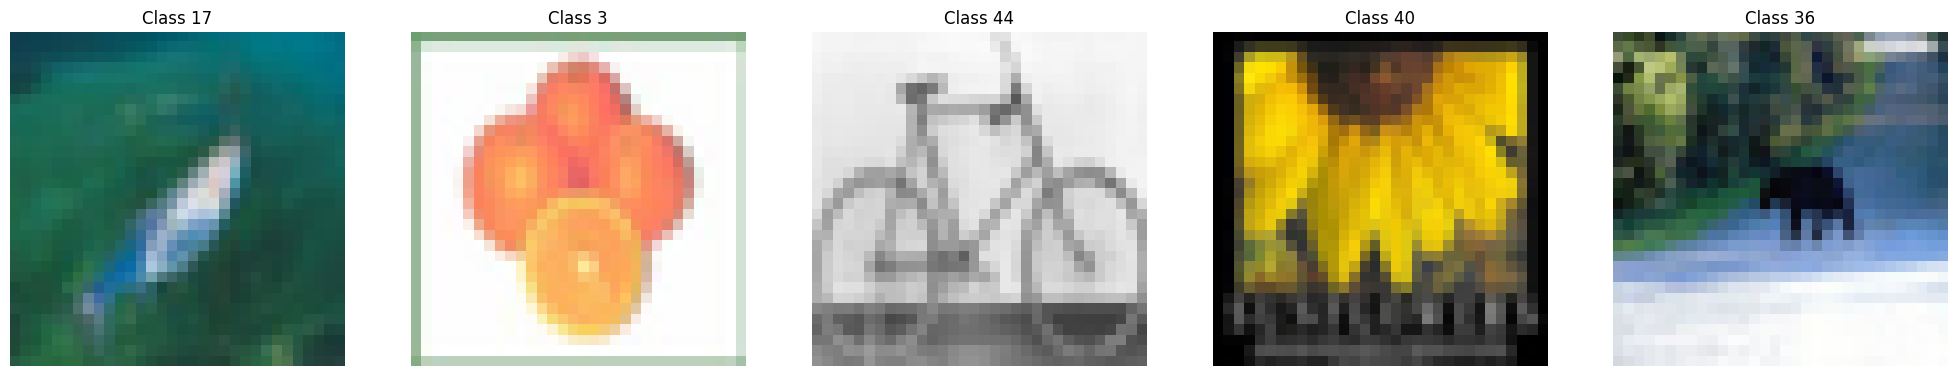

In [6]:
def show_examples(df, n=5):
    fig, axs = plt.subplots(1, n, figsize=(5*n, 5))
    for i in range(n):
        idx = random.randint(0, len(df)-1)
        row = df.iloc[idx]
        img = cv2.imread(row['path'])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        label_name = row['label']
        axs[i].imshow(img)
        axs[i].set_title(f"Class {label_name}")
        axs[i].axis('off')
    plt.show()

show_examples(df, n=5)

Выводы:
- имеем 100 классов,
- ~9500 изображений,
- дисбаланс не очень большой (от 32 до 150 изображений на класс).
- Изображения очень низкого разрешения (32×32).необходимо сделать умеренный Resize(224,224), чтобы EfficientNet мог работать со стандартным разрешением входа.
- Нужно тренировать модель достаточное число эпох, с использованием полноценного файн-тюнинга предобученной модели, а не только обучение последнего слоя.

## Анализ аугментаций

Мы используем albumentations и собираем пайплайны.
Более простые аугментации (только Resize + Flip) и
более сложные (RandomResizedCrop, Affine, Blur, GridDropout и т.д.).

In [4]:
imnet_mean = (0.485, 0.456, 0.406)
imnet_std  = (0.229, 0.224, 0.225)

tf_simple = A.Compose([
    A.Resize(224, 224),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Normalize(mean=imnet_mean, std=imnet_std),
    ToTensorV2()
])

tf_adv = A.Compose([
    A.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0), ratio=(0.75, 1.333)),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Affine(rotate=(-20, 20), scale=(0.8, 1.2), translate_percent=(0.0, 0.2), p=0.7),
    A.RandomBrightnessContrast(p=0.7),
    A.CLAHE(p=0.3),
    A.OneOf([
        A.Blur(blur_limit=3),
        A.GaussianBlur(blur_limit=(3, 7)),
        A.MotionBlur(blur_limit=7),
    ], p=0.3),
    A.GridDropout(ratio=0.5, p=0.5),
    A.Normalize(mean=imnet_mean, std=imnet_std),
    ToTensorV2()
])
tf_val = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=imnet_mean, std=imnet_std),
    ToTensorV2()
])

## Разделение данных, обучение базовой модели

In [5]:
train_df, val_df = train_test_split(
    df, stratify=df.label, test_size=0.15, random_state=42
)
class ImgDS(Dataset):
    def __init__(self, df, transform):
        self.df = df.reset_index(drop=True)
        self.transform = transform
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        img = cv2.imread(self.df.path[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        aug = self.transform(image=img)
        return aug['image'], self.df.label[idx]

def loader(df, bs, tf, shuffle):
    ds = ImgDS(df, tf)
    return DataLoader(
        ds,
        batch_size=bs,
        shuffle=shuffle,
        num_workers=num_workers,
        pin_memory=(device.type=="cuda")
    )

def get_model(pretrain):
    if pretrain:
        m = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
    else:
        m = efficientnet_b0(weights=None)
    m.classifier[-1] = nn.Linear(m.classifier[-1].in_features, len(classes))
    return m.to(device)

In [6]:
def accuracy(pred, gt):
    return (pred.argmax(1) == gt).float().mean().item()

In [7]:
def train(model, train_loader, val_loader, epochs, lr, save_path=None, patience=10):
 
    opt = torch.optim.AdamW(model.parameters(), lr=lr)
    sch = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=epochs)
    crit = nn.CrossEntropyLoss()

    scaler = torch.cuda.amp.GradScaler(enabled=use_amp)

    best_loss = float("inf")
    best_w = None
    no_improve_count = 0 

    history = [[], [], [], []]  # tl, vl, ta, va

    for epoch in range(epochs):
        model.train()
        tl, ta = 0, 0
        pb = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)

        for x, y in pb:
            x, y = x.to(device), y.to(device)
            opt.zero_grad()
            with torch.cuda.amp.autocast(enabled=use_amp):
                out = model(x)
                loss = crit(out, y)

            if use_amp:
                scaler.scale(loss).backward()
                scaler.step(opt)
                scaler.update()
            else:
                loss.backward()
                opt.step()

            tl += loss.item() * len(y)
            ta += (out.argmax(1) == y).float().sum().item()
            pb.set_postfix(loss=f"{loss.item():.4f}")

        tl /= len(train_loader.dataset)
        ta /= len(train_loader.dataset)

        # validation
        model.eval()
        vl, va = 0, 0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                out = model(x)
                vloss = crit(out, y)
                vl += vloss.item() * len(y)
                va += (out.argmax(1) == y).float().sum().item()

        vl /= len(val_loader.dataset)
        va /= len(val_loader.dataset)


        writer.add_scalar("loss/train", tl, epoch)
        writer.add_scalar("loss/val",   vl, epoch)
        writer.add_scalar("acc/train",  ta, epoch)
        writer.add_scalar("acc/val",    va, epoch)

        history[0].append(tl)
        history[1].append(vl)
        history[2].append(ta)
        history[3].append(va)

        # Проверяем val_loss
        if vl < best_loss:
            best_loss = vl
            best_w = model.state_dict().copy()
            no_improve_count = 0
            if save_path is not None:
                torch.save(best_w, save_path)
        else:
            no_improve_count += 1


        sch.step()


        if no_improve_count >= patience:
            print(f"Early stopping on epoch {epoch+1}. Best val_loss={best_loss:.4f}")
            break

    writer.close()


    if save_path is not None:

        best_state = torch.load(save_path)
        model.load_state_dict(best_state)
    else:

        model.load_state_dict(best_w)

    return model, history

In [8]:
def plot_history(history):
    """history = [train_loss, val_loss, train_acc, val_acc]"""
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history[0], label='Train Loss')
    plt.plot(history[1], label='Val Loss')
    plt.legend()
    plt.title("Loss curves")

    plt.subplot(1, 2, 2)
    plt.plot(history[2], label='Train Acc')
    plt.plot(history[3], label='Val Acc')
    plt.legend()
    plt.title("Accuracy curves")

    plt.show()

## Обучение двух моделей:

- Модель без предобученных весов, + простые аугментации
- Модель с предобученными весами + продвинутые аугментации

Epoch 1/20:   0%|          | 0/127 [00:00<?, ?it/s]

Epoch 2/20:   0%|          | 0/127 [00:00<?, ?it/s]

Epoch 3/20:   0%|          | 0/127 [00:00<?, ?it/s]

Epoch 4/20:   0%|          | 0/127 [00:00<?, ?it/s]

Epoch 5/20:   0%|          | 0/127 [00:00<?, ?it/s]

Epoch 6/20:   0%|          | 0/127 [00:00<?, ?it/s]

Epoch 7/20:   0%|          | 0/127 [00:00<?, ?it/s]

Epoch 8/20:   0%|          | 0/127 [00:00<?, ?it/s]

Epoch 9/20:   0%|          | 0/127 [00:00<?, ?it/s]

Epoch 10/20:   0%|          | 0/127 [00:00<?, ?it/s]

Epoch 11/20:   0%|          | 0/127 [00:00<?, ?it/s]

Epoch 12/20:   0%|          | 0/127 [00:00<?, ?it/s]

Epoch 13/20:   0%|          | 0/127 [00:00<?, ?it/s]

Epoch 14/20:   0%|          | 0/127 [00:00<?, ?it/s]

Epoch 15/20:   0%|          | 0/127 [00:00<?, ?it/s]

Epoch 16/20:   0%|          | 0/127 [00:00<?, ?it/s]

Epoch 17/20:   0%|          | 0/127 [00:00<?, ?it/s]

Epoch 18/20:   0%|          | 0/127 [00:00<?, ?it/s]

Epoch 19/20:   0%|          | 0/127 [00:00<?, ?it/s]

Epoch 20/20:   0%|          | 0/127 [00:00<?, ?it/s]

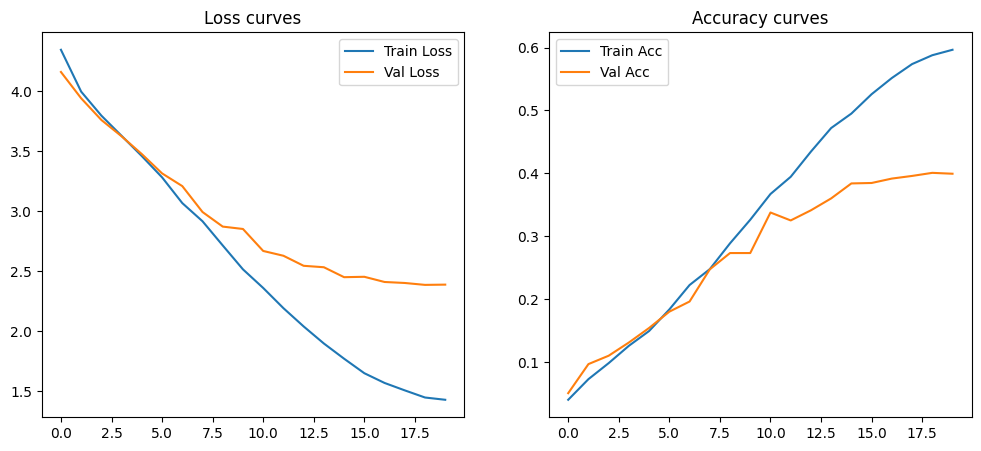

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 98.1MB/s]


Epoch 1/20:   0%|          | 0/127 [00:00<?, ?it/s]

Epoch 2/20:   0%|          | 0/127 [00:00<?, ?it/s]

Epoch 3/20:   0%|          | 0/127 [00:00<?, ?it/s]

Epoch 4/20:   0%|          | 0/127 [00:00<?, ?it/s]

Epoch 5/20:   0%|          | 0/127 [00:00<?, ?it/s]

Epoch 6/20:   0%|          | 0/127 [00:00<?, ?it/s]

Epoch 7/20:   0%|          | 0/127 [00:00<?, ?it/s]

Epoch 8/20:   0%|          | 0/127 [00:00<?, ?it/s]

Epoch 9/20:   0%|          | 0/127 [00:00<?, ?it/s]

Epoch 10/20:   0%|          | 0/127 [00:00<?, ?it/s]

Epoch 11/20:   0%|          | 0/127 [00:00<?, ?it/s]

Epoch 12/20:   0%|          | 0/127 [00:00<?, ?it/s]

Epoch 13/20:   0%|          | 0/127 [00:00<?, ?it/s]

Epoch 14/20:   0%|          | 0/127 [00:00<?, ?it/s]

Epoch 15/20:   0%|          | 0/127 [00:00<?, ?it/s]

Epoch 16/20:   0%|          | 0/127 [00:00<?, ?it/s]

Epoch 17/20:   0%|          | 0/127 [00:00<?, ?it/s]

Epoch 18/20:   0%|          | 0/127 [00:00<?, ?it/s]

Epoch 19/20:   0%|          | 0/127 [00:00<?, ?it/s]

Epoch 20/20:   0%|          | 0/127 [00:00<?, ?it/s]

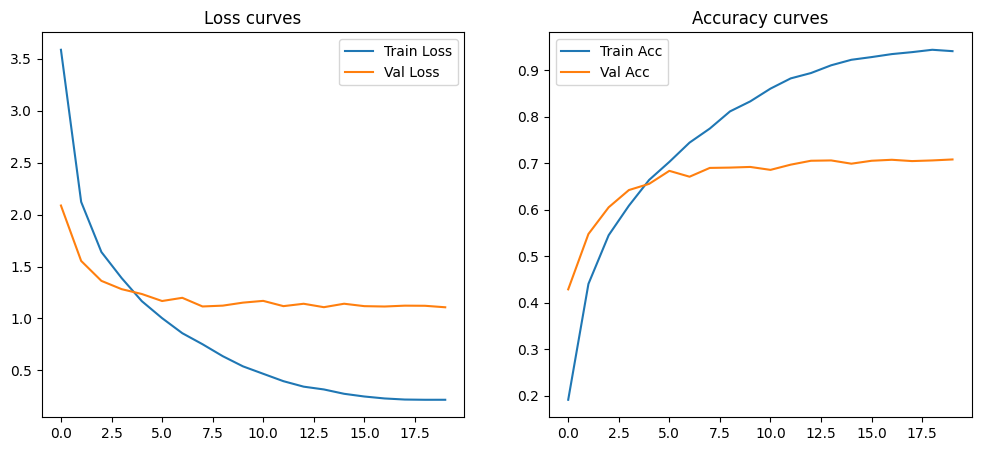

In [9]:
bs = 64
epochs = 20

# модель без предобученных весов, +простые аугментации
train_loader_simple = loader(train_df, bs, tf_simple, shuffle=True)
val_loader         = loader(val_df,   bs, tf_val,    shuffle=False)
model0, hist0      = train(
    get_model(pretrain=False),
    train_loader_simple,
    val_loader,
    epochs,
    lr=1e-3,
    save_path='model0.pth'
)
plot_history(hist0)
# Модель с предобученными весами+ продвинутые аугментации
train_loader_adv = loader(train_df, bs, tf_adv, shuffle=True)
model1, hist1    = train(
    get_model(pretrain=True),
    train_loader_adv,
    val_loader,
    epochs,
    lr=5e-4,
    save_path='model1.pth'
)
plot_history(hist1)




## Дополнительная аугментация с GAN

Обучаем простой генератор + дискриминатор, генерируем синтетические изображения
для увеличения датасета.

Training GAN:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/20:   0%|          | 0/142 [00:00<?, ?it/s]

Epoch 2/20:   0%|          | 0/142 [00:00<?, ?it/s]

Epoch 3/20:   0%|          | 0/142 [00:00<?, ?it/s]

Epoch 4/20:   0%|          | 0/142 [00:00<?, ?it/s]

Epoch 5/20:   0%|          | 0/142 [00:00<?, ?it/s]

Epoch 6/20:   0%|          | 0/142 [00:00<?, ?it/s]

Epoch 7/20:   0%|          | 0/142 [00:00<?, ?it/s]

Epoch 8/20:   0%|          | 0/142 [00:00<?, ?it/s]

Epoch 9/20:   0%|          | 0/142 [00:00<?, ?it/s]

Epoch 10/20:   0%|          | 0/142 [00:00<?, ?it/s]

Epoch 11/20:   0%|          | 0/142 [00:00<?, ?it/s]

Epoch 12/20:   0%|          | 0/142 [00:00<?, ?it/s]

Epoch 13/20:   0%|          | 0/142 [00:00<?, ?it/s]

Epoch 14/20:   0%|          | 0/142 [00:00<?, ?it/s]

Epoch 15/20:   0%|          | 0/142 [00:00<?, ?it/s]

Epoch 16/20:   0%|          | 0/142 [00:00<?, ?it/s]

Epoch 17/20:   0%|          | 0/142 [00:00<?, ?it/s]

Epoch 18/20:   0%|          | 0/142 [00:00<?, ?it/s]

Epoch 19/20:   0%|          | 0/142 [00:00<?, ?it/s]

Epoch 20/20:   0%|          | 0/142 [00:00<?, ?it/s]

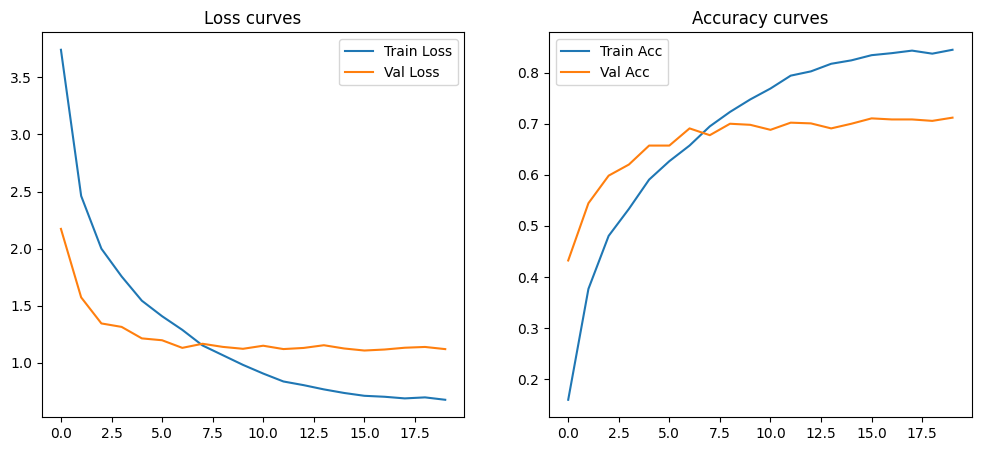

In [10]:
# GAN для дополнительной синтетики

class Dis(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.AdaptiveAvgPool2d((7, 7))
        )
        self.fc = nn.Linear(128*7*7 + len(classes), 1)

    def forward(self, x, y):
        h = self.conv(x).view(x.size(0), -1)
        y_one = F.one_hot(y, num_classes=len(classes)).float()
        return self.fc(torch.cat([h, y_one], dim=1))

class Gen(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(100+len(classes), 128*7*7)
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, 4, 2, 1),
            nn.Tanh()
        )
    def forward(self, z, y):
        y_one = F.one_hot(y, num_classes=len(classes)).float()
        x = torch.cat([z, y_one], dim=1)
        x = self.fc(x).view(-1, 128, 7, 7)
        return self.deconv(x)

# GAN
g, d = Gen().to(device), Dis().to(device)
opt_g = torch.optim.Adam(g.parameters(), 2e-4, betas=(0.5, 0.999))
opt_d = torch.optim.Adam(d.parameters(), 2e-4, betas=(0.5, 0.999))

gan_loader = loader(df, 128, tf_val, shuffle=True)

for _ in tqdm(range(5), desc='Training GAN'):
    for real_x, real_y in gan_loader:
        real_x = (real_x.to(device)*2 - 1)
        real_y = real_y.to(device)

        # шаг дискриминатора
        z = torch.randn(real_x.size(0), 100, device=device)
        fake_x = g(z, real_y)

        real_loss = F.binary_cross_entropy_with_logits(
            d(real_x, real_y),
            torch.ones(real_x.size(0), 1, device=device)
        )
        fake_loss = F.binary_cross_entropy_with_logits(
            d(fake_x.detach(), real_y),
            torch.zeros(real_x.size(0), 1, device=device)
        )

        opt_d.zero_grad()
        (real_loss + fake_loss).backward()
        opt_d.step()

        # Шаг генератора
        opt_g.zero_grad()
        gen_loss = F.binary_cross_entropy_with_logits(
            d(fake_x, real_y),
            torch.ones(real_x.size(0), 1, device=device)
        )
        gen_loss.backward()
        opt_g.step()


synth_paths, synth_labels = [], []
os.makedirs('data/synth', exist_ok=True)
for c in range(len(classes)):
    for i in range(10):
        z = torch.randn(1, 100, device=device)
        y = torch.tensor([c], device=device)
        with torch.no_grad():
            img = g(z, y)[0]
            img = (img.permute(1, 2, 0).cpu().numpy() + 1) / 2 * 255
            img = img.clip(0, 255).astype(np.uint8)
        path = f'data/synth/{c}_{i}.png'
        cv2.imwrite(path, cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
        synth_paths.append(path)
        synth_labels.append(c)

df_synth = pd.DataFrame({'path': synth_paths, 'label': synth_labels})
df_aug   = pd.concat([train_df, df_synth]).reset_index(drop=True)

# Обучаем модель на расширенном датасете
model2, hist2 = train(
    get_model(pretrain=True),
    loader(df_aug, bs, tf_adv, shuffle=True),
    val_loader,
    epochs,
    lr=5e-4,
    save_path='model2.pth'
)

plot_history(hist2)



## Финальная модель с предобученными весами + продвинутые аугментации + обучение на расширенном датасете

In [11]:
# Предсказания на тесте для submit

test_paths = glob.glob(os.path.join(test_root, '*'))

# Извлекаем id из названия файла"123.png" -> 123
def get_id_from_filename(path):
    base = os.path.basename(path)
    idx_str = os.path.splitext(base)[0]
    return int(idx_str)

test_ids = [get_id_from_filename(p) for p in test_paths]

test_df = pd.DataFrame({'path': test_paths, 'id': test_ids})

test_df = test_df.sort_values('id').reset_index(drop=True)

class TestDS(Dataset):
    def __init__(self, df, tf):
        self.df = df
        self.transform = tf
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        img = cv2.imread(self.df.path[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        aug = self.transform(image=img)
        return aug['image'], idx 

test_dataset = TestDS(test_df, tf_val)
test_loader  = DataLoader(
    test_dataset,
    batch_size=bs,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=(device.type=="cuda")
)

model2.eval()
preds = np.zeros(len(test_df), dtype=int)

with torch.no_grad():
    for x, idxs in test_loader:
        x = x.to(device)
        out = model2(x)
        # модель выдаёт logits берём argmax
        predicted = out.argmax(1).cpu().numpy()
        preds[idxs] = predicted

submission = pd.DataFrame({
    'id': test_df['id'],
    'target': preds
})
submission.to_csv('submission_new.csv', index=False)
print('Saved submission_new.csv')

Saved submission_new.csv


In [12]:

test_dataset = TestDS(test_df, tf_val)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)

model0.eval()
preds0 = []
with torch.no_grad():
    for x, idxs in test_loader:
        x = x.to(device)
        out = model0(x)
        preds0.extend(out.argmax(1).cpu().numpy())

submission0 = pd.DataFrame({
    'id': test_df['id'],
    'target': preds0
})
submission0.to_csv('submission_model0.csv', index=False)
print("Saved submission_model0.csv")


model1.eval()
preds1 = []
with torch.no_grad():
    for x, idxs in test_loader:
        x = x.to(device)
        out = model1(x)
        preds1.extend(out.argmax(1).cpu().numpy())

submission1 = pd.DataFrame({
    'id': test_df['id'],
    'target': preds1
})
submission1.to_csv('submission_model1.csv', index=False)
print("Saved submission_model1.csv")


model2.eval()
preds2 = []
with torch.no_grad():
    for x, idxs in test_loader:
        x = x.to(device)
        out = model2(x)
        preds2.extend(out.argmax(1).cpu().numpy())

submission2 = pd.DataFrame({
    'id': test_df['id'],
    'target': preds2
})
submission2.to_csv('submission_model2.csv', index=False)
print("Saved submission_model2.csv")

Saved submission_model0.csv
Saved submission_model1.csv
Saved submission_model2.csv


In [13]:
import os
import pandas as pd

classes_lex = sorted(os.listdir(train_root))     
classes_num = sorted(os.listdir(train_root), key=lambda x: int(x))

old_c2idx = {c: i for i, c in enumerate(classes_lex)}

new_c2idx = {c: i for i, c in enumerate(classes_num)}


old_idx2c = {v: k for k, v in old_c2idx.items()}

def fix_label(old_label: int) -> int:
    class_name = old_idx2c[old_label]
    new_label  = new_c2idx[class_name]
    return new_label



def join_labels(preds_path):

    submission_old = pd.read_csv(preds_path) 
    
    submission_old['target'] = submission_old['target'].apply(fix_label)
    
    submission_old.to_csv(preds_path, index=False)


join_labels('submission_model0.csv')
join_labels('submission_model1.csv')
join_labels('submission_model2.csv')

In [ ]:
1